In [23]:
!pip3 install nufeb-tools -U --quiet

Traceback (most recent call last):
  File "C:\Users\Jonathan\anaconda3\envs\nufeb\Scripts\pip3-script.py", line 6, in <module>
    from pip._internal.cli.main import main
ModuleNotFoundError: No module named 'pip._internal.cli.main'


In [24]:
#Imports
import os
from random import uniform
import subprocess
from pathlib import Path
from nufeb_tools import utils,plot
import pandas as pd
from string import Template
import numpy as np
from functools import partial
import time
from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize
from skopt.plots import plot_convergence, plot_objective
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from skopt import dump, load
from skopt.callbacks import CheckpointSaver

In [25]:
test_data = pd.read_excel('../experimental-data/sucrose-OD-IPTG-sweep.xls',sheet_name='data')
from scipy.optimize import curve_fit
def od_func(x):
    """Exponential fit to IPTG vs OD750 experimental data

    Args:
        x (float): IPTG concentration (mM)

    Returns:
        float: Smoothed OD750
    """
    return 0.25482 * np.exp(-x/.06811) + 1.12893
def suc_func(x,a,b,c):
    return a*np.exp(-x/b)+c
# Smooth OD750 data for fitting
test_data.loc[:,'OD750'] = od_func(test_data.IPTG)

In [26]:
def recompile(alpha,tau,c):
    os.chdir('/tmp/NUFEB')
    filein = open( f'/home/12x/nufeb-cyano-e-coli/templates/fix_bio_kinetics_monod2.txt' )
    #read it
    src = Template( filein.read() )
    #do the substitution
    result = src.safe_substitute({'alpha' : alpha, 'tau' : tau, 'c' : c,'alpha2' : alpha2, 'tau2' : tau2, 'c2' : c2
                                        
                                        })
    with open("/tmp/NUFEB/src/USER-NUFEB/fix_bio_kinetics_monod.cpp","w") as f:
       f.writelines(result)
    #Compile NUFEB
    nufeb_compile = subprocess.run('/home/12x/rapid-compile.sh')

In [27]:
def func(x):

    alpha = x[0]
    tau = x[1]
    c = x[2]
    #alpha2= 0.7917548932118175
    #tau2= 9.928116064234674
    #c2= 0.017154626440951674





    #Change input params
    
    os.chdir('/tmp/NUFEB')
    recompile(alpha,tau,c)
    print(f'alpha: {alpha},tau: {tau},c: {c}')

    #Clean old simulations
    os.system('nufeb-clean')
    #Run simulation
    for iptg in test_data.IPTG:
        text = f'nufeb-seed --cells 100,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --mucya {mu} --sucR {iptg}'
        os.system(text)

    run_nufeb = subprocess.run('/home/12x/optim2.sh', stdout=subprocess.DEVNULL)
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

    #Extract output

    data = [utils.get_data(directory=str(x)) for x in folders]
    Volume = 1e-4*1e-4*1e-4 #m^3
    CellNum2OD = Volume*1e6/0.3e-8
    SucroseMW = 342.3
    dfs = []
    for x in data:
        temp = pd.concat([x.ntypes.cyano/CellNum2OD,x.ntypes.step/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
        temp.columns=['OD750','Hours','Sucrose']
        temp['IPTG'] = x.metadata['SucRatio']
        dfs.append(temp)
    df = pd.concat(dfs,ignore_index=True)
    df = df.loc[(df.Hours > 23.8) & (df.Hours < 24)]
    df.sort_values(by='IPTG',inplace=True)
    df.reset_index(inplace=True)
    

    #Compare output with experimental data via RMSE
    
    return mean_squared_error(df.OD750,test_data.OD750, squared = False) + mean_squared_error(df.Sucrose,test_data.Sucrose, squared = False)




# Growth curve fitting

In [28]:
res = load('../checkpoints/checkpoint-se-od-icer.pkl')
x0 = res.x_iters
y0 = res.func_vals
          #  x0=x0,              # already examined values for x
       #     y0=y0,              # observed values for x0

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

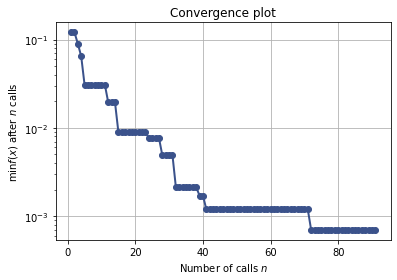

In [29]:
plot_convergence(res,yscale='log')

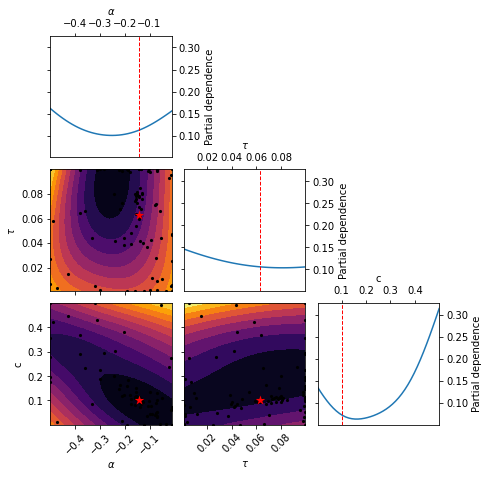

In [30]:
axes = plot_objective(res,dimensions=[r'$\alpha$',r'$\tau$','c'],cmap='inferno')
#axes.flatten()[0].figure.savefig("../figures/se-objective.png")

In [31]:
res.x

[-0.14096531237477777, 0.06278980692474602, 0.10023045545531656]

# Sucrose export fitting

In [32]:
res = load('../checkpoints/checkpoint-se-suc-icer.pkl')

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

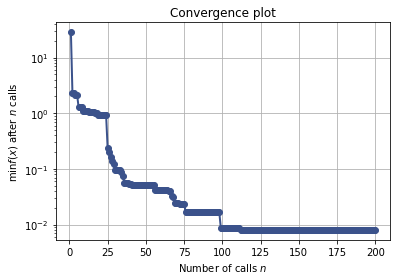

In [33]:
plot_convergence(res,yscale='log')

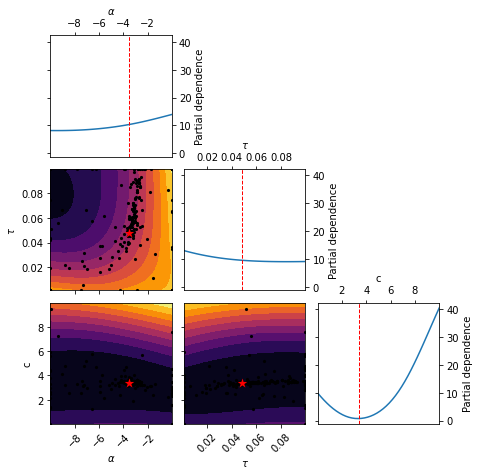

In [34]:
axes = plot_objective(res,dimensions=[r'$\alpha$',r'$\tau$','c'],cmap='inferno')
#axes.flatten()[0].figure.savefig("../figures/se-objective.png")

In [35]:
res.x

[-3.4897341206041004, 0.048054721764639076, 3.4091902801428087]